In [ ]:
# === Batch Fungal Germination Counter (µm + spore-diameter rule) =============
# Classifies spores as germinated if germ tube length ≥ 1× that spore’s diameter

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds
MIN_AREA = 25
MAX_AREA = 10000
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True

# Scale & germination rule
UM_PER_PX = 0.22          # <-- set from your calibration
MIN_TUBE_MULTIPLE = 1.0   # tube must be ≥ 1× that spore’s diameter
BORDERLINE_UM = 1.0       # objects within ±1 µm of cutoff are flagged
MIN_SOLIDITY = 0.80
MIN_CIRCULARITY = 0.55
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    th = filters.threshold_sauvola(blur, window_size=61, k=0.2)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        h = 0.6 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1
        dist_h = morphology.h_maxima(dist, h=h)
        seeds = measure.label(dist_h)
        labels = segmentation.watershed(-dist, seeds, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue
        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv_px = p.equivalent_diameter
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))

        if solidity < MIN_SOLIDITY and circularity < MIN_CIRCULARITY:
            continue

        skel = morphology.skeletonize(labels == p.label)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um = max(0.0, sklen_um - equiv_um)

        cutoff_um = MIN_TUBE_MULTIPLE * equiv_um
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "aspect_ratio": float(aspect),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    # ✅ ensure DataFrame has correct schema even if no spores are detected
    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","aspect_ratio","equiv_diameter_um",
            "skeleton_len_um","germ_tube_um","cutoff_um",
            "solidity","circularity","is_germinated","margin_um"
        ]), overlay

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    germ_count = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={germ_count}  overlay={os.path.basename(out_png)}")

big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big_border = big.loc[border].copy()
    big_border.to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# ----------------------- SUMMARIES -------------------------------------------
if "is_germinated" in big:
    per_file = big.groupby("file").agg(
        total=("is_germinated","count"),
        germinated=("is_germinated","sum")
    ).reset_index()
    per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
    per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)

    per_file_with_meta = per_file.merge(
        big[["file","strain","temp"]].drop_duplicates(), on="file", how="left"
    )
    summary = (
        per_file_with_meta
        .groupby(["strain","temp"])["percent_germinated"]
        .agg(["mean","std","count"])
        .reset_index()
    )
    summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
    summary["ci95"] = 1.96 * summary["sem"]
    summary = summary.sort_values(["strain","temp"])
    summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

    # ----------------------- PLOTS -------------------------------------------
    plt.figure(figsize=(10, 5))
    order = per_file.sort_values("percent_germinated", ascending=False)
    plt.bar(order["file"], order["percent_germinated"])
    plt.xticks(rotation=80, ha="right")
    plt.ylabel("% germinated")
    plt.title("Per-image % germinated")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
    plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% germinated")
    plt.title("Grouped by strain × temp (mean ± SD)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% germinated")
    plt.title("Grouped by strain × temp (mean ± 95% CI)")
    plt.tight_layout()
    plt.show()


Found 1 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg']
ku80_37 (2).jpg -> N=323  germinated=104  (32.2%)  seeds=peak(fp=7)  overlay=ku80_37 (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_perimage_summary.csv


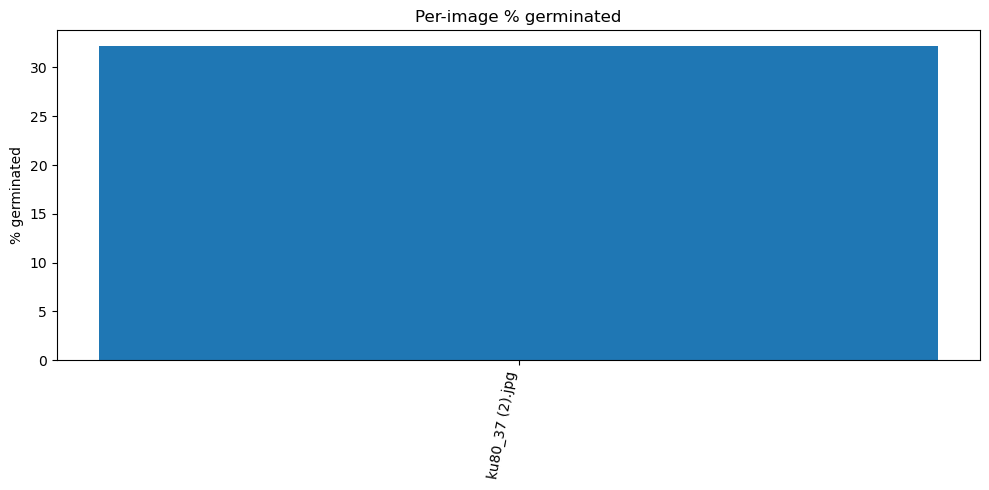

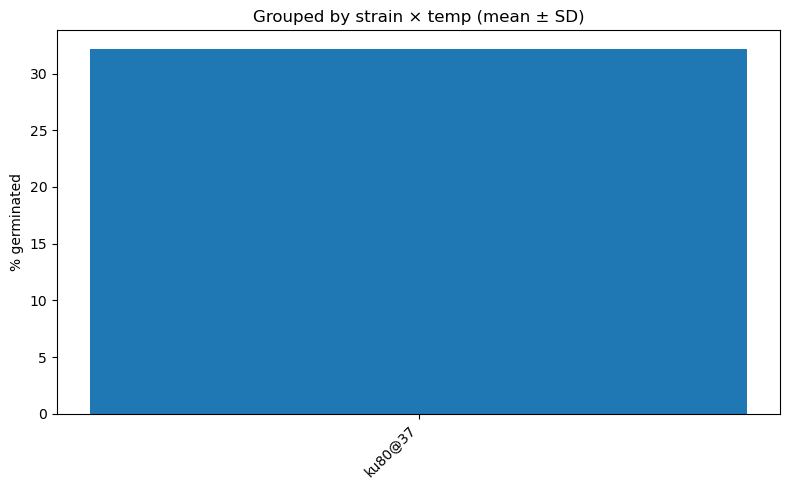

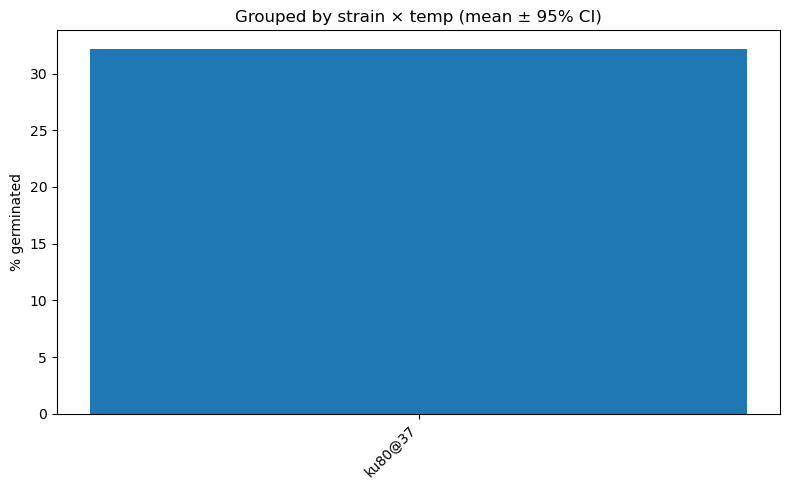

In [1]:
# === Batch Fungal Germination Counter (40×, µm + spore-diameter rule) ========
# Germinated if germ tube length ≥ 1× that spore’s diameter (in µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# 40× tuned thresholds
MIN_AREA = 100          # px^2 (exclude tiny debris)
MAX_AREA = 3000         # px^2 (avoid merged clusters)
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True

# Scale & germination rule
UM_PER_PX = 0.22        # <-- set from your 100 µm scalebar (example value)
MIN_TUBE_MULTIPLE = 1.0 # tube must be ≥ 1× that spore’s diameter
BORDERLINE_UM = 1.0     # save objects within ±1 µm of cutoff for QC

# debris/shape guards
MIN_SOLIDITY = 0.80
MIN_CIRCULARITY = 0.55  # 4πA/P^2 (round≈1.0)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)

    # ---- build mask helper (gentler for 40×) ----
    def build_mask(base):
        blur = filters.gaussian(base, sigma=GAUSSIAN_SIGMA)
        th = filters.threshold_sauvola(blur, window_size=41, k=0.12)  # 40×-friendly
        bw = blur > th
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)      # keep small seeds
        bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))
        bw = morphology.binary_closing(bw, morphology.disk(OPENING_RADIUS))
        return bw

    # ---- polarity auto-pick ----
    bw_n = build_mask(g)
    bw_i = build_mask(1.0 - g)

    def quality(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        frac_big = (max(areas) / max(1, int(mask.sum()))) if areas else 1.0
        return len(ok), frac_big, lab

    nN, fN, labN = quality(bw_n)
    nI, fI, labI = quality(bw_i)
    if (nI > nN) or (nI == nN and fI < fN):
        bw, labels0, chosen_polarity = bw_i, labI, "invert"
    else:
        bw, labels0, chosen_polarity = bw_n, labN, "normal"

    # ---- adaptive seeding (40×) ----
    dist = ndi.distance_transform_edt(bw)

    # A) peak_local_max with small footprint (dense clusters at 40×)
    fp = (7, 7)
    coordsA = feature.peak_local_max(dist, footprint=np.ones(fp), labels=bw, exclude_border=False)
    seedsA = np.zeros_like(dist, dtype=bool)
    if coordsA.size:
        seedsA[tuple(coordsA.T)] = True
    labA = segmentation.watershed(-dist, measure.label(seedsA), mask=bw)
    nA, fA, _ = quality(labA > 0)

    # B) h-maxima (older method; good for very dense blobs)
    h = 0.45 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
    hmax = morphology.h_maxima(dist, h=h)
    labB = segmentation.watershed(-dist, measure.label(hmax), mask=bw)
    nB, fB, _ = quality(labB > 0)

    # choose better split
    if (nB > nA) or (nB == nA and fB < fA):
        labels, seed_method = labB, f"hmax(h={h:.2f})"
    else:
        labels, seed_method = labA, f"peak(fp={fp[0]})"

    # sanity fallback: if still under-segmented, densify peaks
    n_ok, frac_big, _ = quality(labels > 0)
    if n_ok < 30 or frac_big > 0.40:
        fp2 = (5, 5)
        coords2 = feature.peak_local_max(dist, footprint=np.ones(fp2), labels=bw, exclude_border=False)
        seeds2 = np.zeros_like(dist, dtype=bool)
        if coords2.size:
            seeds2[tuple(coords2.T)] = True
        lab2 = segmentation.watershed(-dist, measure.label(seeds2), mask=bw)
        n2, f2, _ = quality(lab2 > 0)
        if (n2 > n_ok) or (n2 == n_ok and f2 < frac_big):
            labels, seed_method = lab2, f"peak(fp={fp2[0]})*"

    # debug: save the chosen mask for QC
    dbg_mask_path = os.path.splitext(path)[0] + f"_mask_{chosen_polarity}.png"
    try:
        io.imsave(dbg_mask_path, util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- measure + classify (tube ≥ 1× spore diameter) ----
    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if solidity < MIN_SOLIDITY and circularity < MIN_CIRCULARITY:
            continue

        equiv_px = p.equivalent_diameter
        skel = morphology.skeletonize(labels == p.label)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)
        cutoff_um = MIN_TUBE_MULTIPLE * equiv_um
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "seed_method": seed_method,
            "polarity": chosen_polarity
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        # keep schema if nothing detected
        return pd.DataFrame(columns=[
            "file","label","area_px","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity",
            "is_germinated","margin_um","seed_method","polarity"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []  # for a concise per-image CSV

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    # overlay save
    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    # per-image summary
    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    # pick one seed/polarity (they're constant for an image)
    seed_method = df["seed_method"].iloc[0] if "seed_method" in df and len(df) else "NA"
    polarity    = df["polarity"].iloc[0] if "polarity" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None
    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "polarity": polarity, "seed_method": seed_method
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  seeds={seed_method}  overlay={os.path.basename(out_png)}")

# concatenate per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_file = per_image.rename(columns={
        "file":"file",
        "percent_germinated":"percent_germinated"
    })[["file","total","germinated","percent_germinated"]]
    per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)

    # attach meta and group
    per_image_with_meta = per_image.copy()
    summary = (
        per_image_with_meta
        .dropna(subset=["strain","temp"])
        .groupby(["strain","temp"])["percent_germinated"]
        .agg(["mean","std","count"])
        .reset_index()
    )
    if not summary.empty:
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # ----------------------- PLOTS ---------------------------------------
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
        plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± SD)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± 95% CI)")
        plt.tight_layout()
        plt.show()


Found 1 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg']
ku80_37 (2).jpg -> N=119  germinated=2  (1.7%)  mask=yen_invert  seed_min_dist=8  overlay=ku80_37 (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_perimage_summary.csv


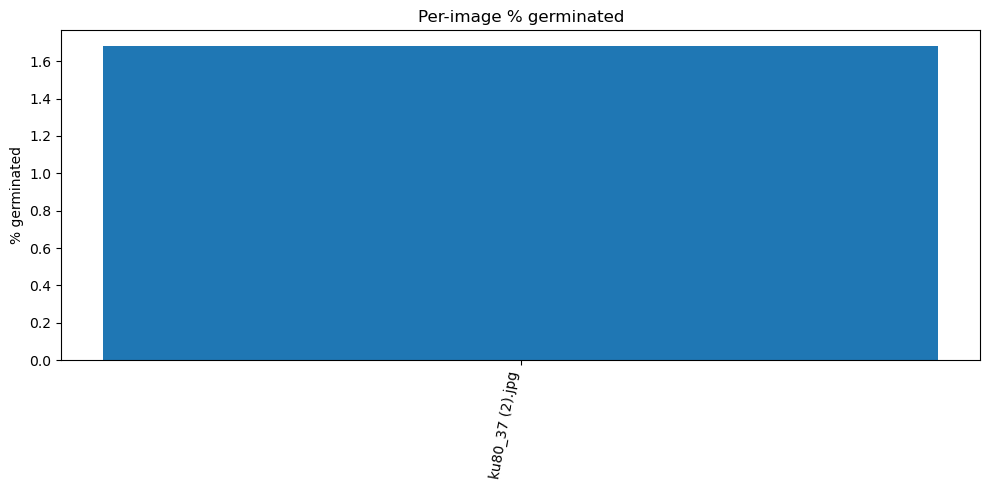

NameError: name 'labe' is not defined

<Figure size 800x500 with 0 Axes>

In [4]:
# === Batch Fungal Germination Counter (40×, robust) ==========================
# Germinated if germ tube length ≥ 1× that spore’s diameter (in µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# 40× tuned thresholds (balanced for real spores, not fragments)
MIN_AREA = 150           # px^2  (allow faint single spores; raise if fragments remain)
MAX_AREA = 1500          # px^2  (avoid merged clusters)
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 96
WATERSHED_SPLIT = True

# Adaptive Sauvola (gentler) for 40×
SAUVOLA_WINDOW = 41
SAUVOLA_K = 0.12

# Scale & germination rule
UM_PER_PX = 0.22         # <-- set from your 100 µm scale bar (example value)
MIN_TUBE_MULTIPLE = 1.0  # tube must be ≥ 1× that spore’s diameter
BORDERLINE_UM = 1.0      # save objects within ±1 µm of cutoff for QC

# debris/shape guards
MIN_SOLIDITY = 0.80
MIN_CIRCULARITY = 0.55   # 4πA/P^2 (round≈1.0)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)

    # ---- robust masking: try multiple methods and pick the best ----
    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)  # fill donut halos
        bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))
        bw = morphology.binary_closing(bw, morphology.disk(OPENING_RADIUS))
        return bw

    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)
        frac_big = (max(areas)/max(1, int(mask.sum()))) if areas else 1.0
        # more ok objects and smaller largest-component fraction are better
        return (n_ok, -frac_big)

    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    # Candidates: Sauvola (normal & inverted) + global thresholds on inverted
    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bwN = cleanup(blur > thN)
    bwI = cleanup(blur_inv > thI)

    otsu = filters.threshold_otsu(blur_inv)
    yen  = filters.threshold_yen(blur_inv)
    tri  = filters.threshold_triangle(blur_inv)
    bwO = cleanup(blur_inv > otsu)
    bwY = cleanup(blur_inv > yen)
    bwT = cleanup(blur_inv > tri)

    candidates = [("sauv_normal", bwN), ("sauv_invert", bwI),
                  ("otsu_invert", bwO), ("yen_invert", bwY), ("tri_invert", bwT)]
    scored = [(name, mask, score_mask(mask)) for name, mask in candidates]
    name, bw, _ = max(scored, key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (prevents over-splitting) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0
    min_dist = int(np.clip(0.25 * med_eq_px, 6, 14))  # seed spacing

    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: if still under-segmented (giant blob), try h-maxima split
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.45 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big

        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ 1× spore diameter) ----
    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if solidity < MIN_SOLIDITY and circularity < MIN_CIRCULARITY:
            continue

        equiv_px = p.equivalent_diameter
        skel = morphology.skeletonize(labels == p.label)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)
        cutoff_um = MIN_TUBE_MULTIPLE * equiv_um
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        # keep schema if nothing detected
        return pd.DataFrame(columns=[
            "file","label","area_px","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity",
            "is_germinated","margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # PLOTS
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        labe


Found 1 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg']
ku80_37 (2).jpg -> N=91  germinated=32  (35.2%)  mask=otsu_invert  seed_min_dist=14  overlay=ku80_37 (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_perimage_summary.csv


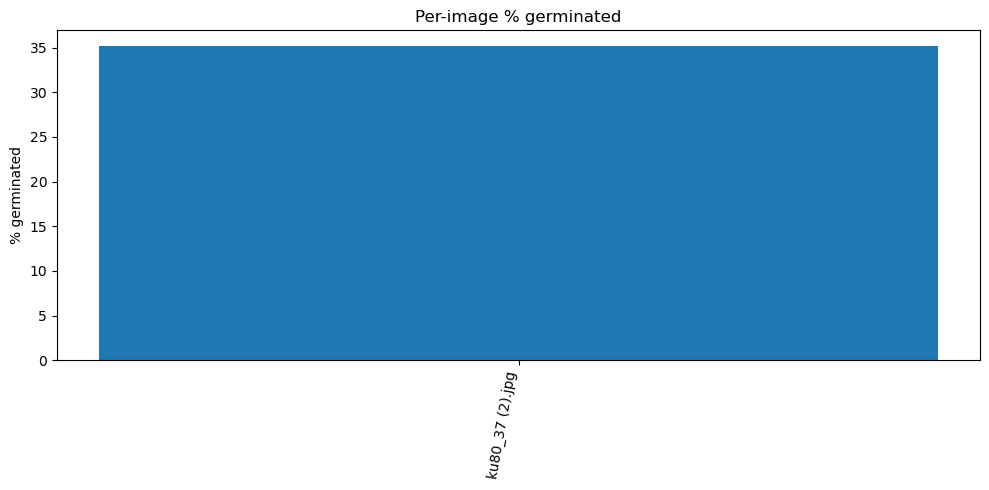

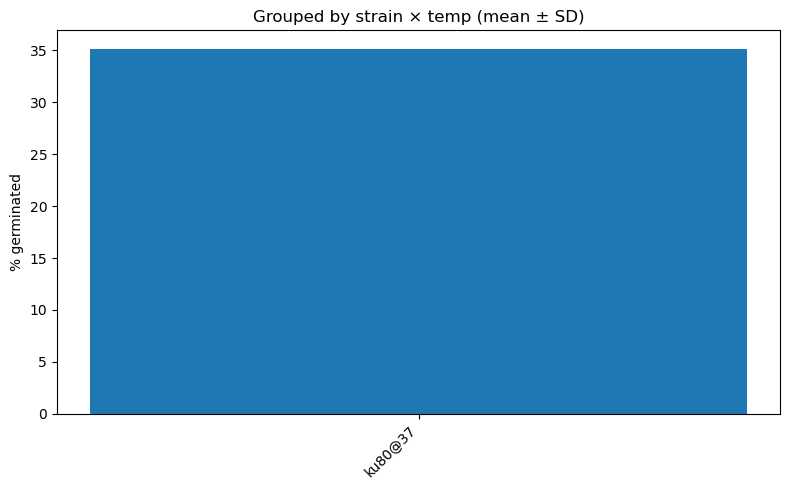

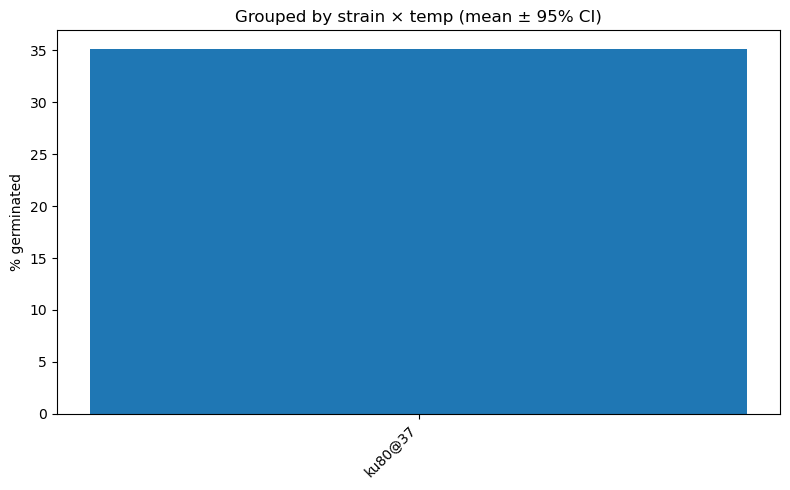

In [10]:
# === Batch Fungal Germination Counter (40×, robust v3) =======================
# Germinated if germ tube length ≥ 0.8 × that spore’s diameter (in µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# 40× tuned thresholds (patched to keep spore–tube connections)
MIN_AREA = 200           # px^2 (raise if fragments remain: 170–200)
MAX_AREA = 1800          # px^2 (lower if big blobs slip through)
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 0       # <-- no opening; don't break thin tubes
HOLE_AREA = 96
WATERSHED_SPLIT = True

# Adaptive Sauvola (gentler) for 40×
SAUVOLA_WINDOW = 41
SAUVOLA_K = 0.12

# Scale & germination rule
UM_PER_PX = 0.22         # <-- set from your 100 µm scale bar
MIN_TUBE_MULTIPLE = 0.8  # tube must be ≥ 0.8× that spore’s diameter
BORDERLINE_UM = 1.0

# debris/shape guards (looser to keep thin hyphae)
MIN_SOLIDITY = 0.80      # kept for reference, not used directly now
MIN_CIRCULARITY = 0.55   # kept for reference, not used directly now
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)

    # ---- robust masking: try multiple methods, pick best ----
    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)           # solid spores (no ring fragments)
        # no opening; DO a slightly stronger closing to keep spore–tube bridges
        bw = morphology.binary_closing(bw, morphology.disk(2))
        return bw

    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)
        frac_big = (max(areas)/max(1, int(mask.sum()))) if areas else 1.0
        return (n_ok, -frac_big)  # higher is better

    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bwN = cleanup(blur > thN)
    bwI = cleanup(blur_inv > thI)

    otsu = filters.threshold_otsu(blur_inv)
    yen  = filters.threshold_yen(blur_inv)
    tri  = filters.threshold_triangle(blur_inv)
    bwO = cleanup(blur_inv > otsu)
    bwY = cleanup(blur_inv > yen)
    bwT = cleanup(blur_inv > tri)

    candidates = [("sauv_normal", bwN), ("sauv_invert", bwI),
                  ("otsu_invert", bwO), ("yen_invert", bwY), ("tri_invert", bwT)]
    name, bw, _ = max(((nm, m, score_mask(m)) for nm, m in candidates), key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (denser split) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    # denser seeding: 0.30 × median spore diameter, clipped to 10–16 px
    #min_dist = int(np.clip(0.30 * med_eq_px, 10, 16))
    #min_dist = int(np.clip(0.35 * med_eq_px, 12, 18))
    min_dist = int(np.clip(0.40 * med_eq_px, 14, 20))

    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: if under-segmented (giant component), try h-maxima split
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.45 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ 0.8× diameter) ----
    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))

        # Looser debris guard: drop only wisps; keep thin hyphae
        if (solidity < 0.45 and circularity < 0.25):
            continue

        equiv_px = p.equivalent_diameter

        # --- measure skeleton on a 1-px dilated region to keep continuity
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(1))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)
        cutoff_um = MIN_TUBE_MULTIPLE * equiv_um
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity",
            "is_germinated","margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # PLOTS
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
        plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± SD)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± 95% CI)")
        plt.tight_layout()
        plt.show()


Found 2 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1).jpg']
ku80_37 (2).jpg -> N=91  germinated=15  (16.5%)  mask=otsu_invert  seed_min_dist=14  overlay=ku80_37 (2)_overlay.png
nrc1_37_40X (1).jpg -> N=48  germinated=7  (14.6%)  mask=otsu_invert  seed_min_dist=14  overlay=nrc1_37_40X (1)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurem

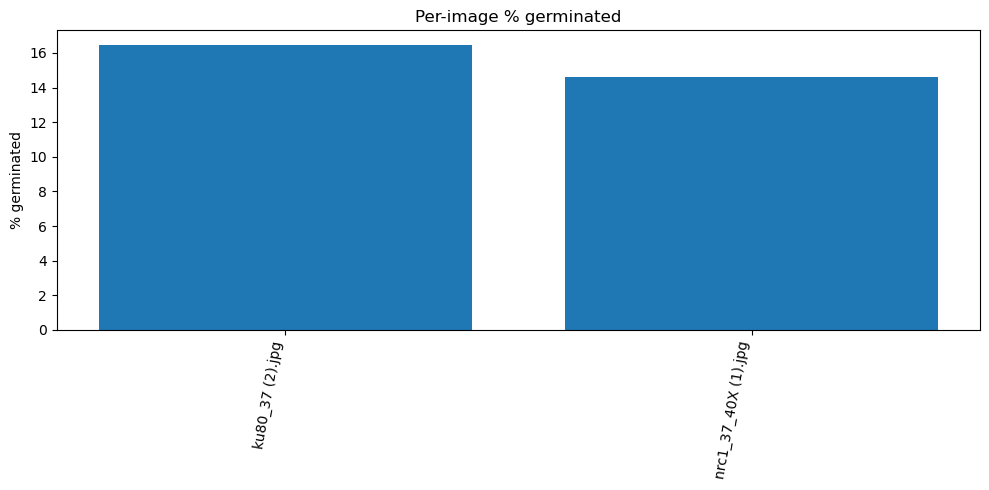

/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


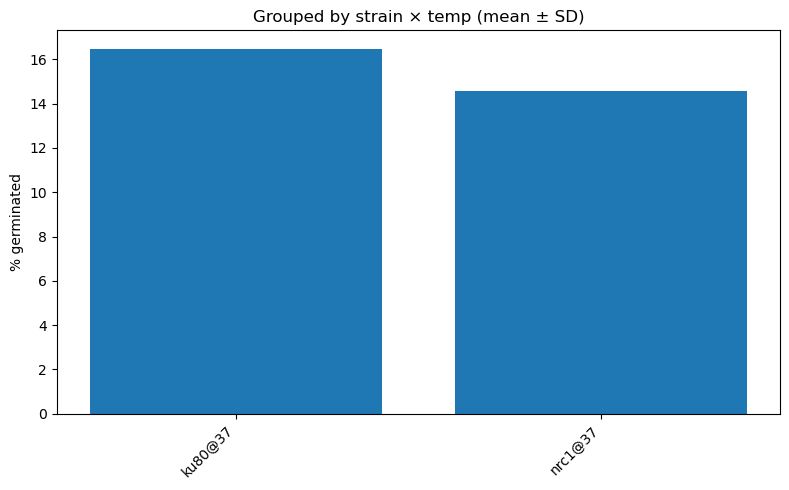

/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


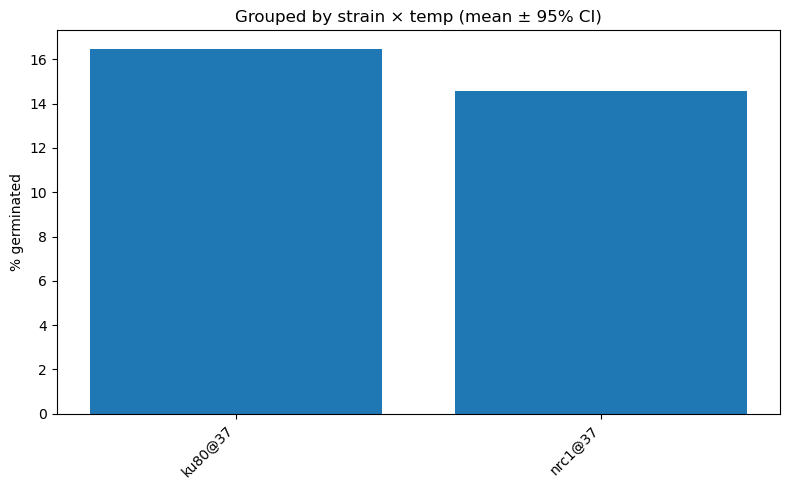

In [1]:
# === Batch Fungal Germination Counter (40×, robust v3) =======================
# Germinated if germ tube length ≥ 0.8 × that spore’s diameter (in µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# 40× tuned thresholds (patched to keep spore–tube connections)
MIN_AREA = 200           # px^2 (raise if fragments remain: 170–200)
MAX_AREA = 1800          # px^2 (lower if big blobs slip through)
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 0       # <-- no opening; don't break thin tubes
HOLE_AREA = 96
WATERSHED_SPLIT = True

# Adaptive Sauvola (gentler) for 40×
SAUVOLA_WINDOW = 41
SAUVOLA_K = 0.12

# Scale & germination rule
UM_PER_PX = 0.22         # <-- set from your 100 µm scale bar
MIN_TUBE_MULTIPLE = 1.2  # tube must be ≥ 0.8× that spore’s diameter
BORDERLINE_UM = 1.0

# debris/shape guards (looser to keep thin hyphae)
MIN_SOLIDITY = 0.80      # kept for reference, not used directly now
MIN_CIRCULARITY = 0.55   # kept for reference, not used directly now
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)

    # ---- robust masking: try multiple methods, pick best ----
    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)           # solid spores (no ring fragments)
        # no opening; DO a slightly stronger closing to keep spore–tube bridges
        bw = morphology.binary_closing(bw, morphology.disk(2))
        return bw

    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)
        frac_big = (max(areas)/max(1, int(mask.sum()))) if areas else 1.0
        return (n_ok, -frac_big)  # higher is better

    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bwN = cleanup(blur > thN)
    bwI = cleanup(blur_inv > thI)

    otsu = filters.threshold_otsu(blur_inv)
    yen  = filters.threshold_yen(blur_inv)
    tri  = filters.threshold_triangle(blur_inv)
    bwO = cleanup(blur_inv > otsu)
    bwY = cleanup(blur_inv > yen)
    bwT = cleanup(blur_inv > tri)

    candidates = [("sauv_normal", bwN), ("sauv_invert", bwI),
                  ("otsu_invert", bwO), ("yen_invert", bwY), ("tri_invert", bwT)]
    name, bw, _ = max(((nm, m, score_mask(m)) for nm, m in candidates), key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (denser split) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    # denser seeding: 0.30 × median spore diameter, clipped to 10–16 px
    #min_dist = int(np.clip(0.30 * med_eq_px, 10, 16))
    #min_dist = int(np.clip(0.35 * med_eq_px, 12, 18))
    min_dist = int(np.clip(0.40 * med_eq_px, 14, 20))

    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: if under-segmented (giant component), try h-maxima split
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.45 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ 0.8× diameter) ----
    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))

        # Looser debris guard: drop only wisps; keep thin hyphae
        if (solidity < 0.45 and circularity < 0.25):
            continue

        equiv_px = p.equivalent_diameter

        # --- measure skeleton on a 1-px dilated region to keep continuity
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(1))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)
        #cutoff_um = MIN_TUBE_MULTIPLE * equiv_um
        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, 5.0)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity",
            "is_germinated","margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # PLOTS
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
        plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± SD)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± 95% CI)")
        plt.tight_layout()
        plt.show()


Found 3 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ptp3_37_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1).jpg']
ku80_37 (2).jpg -> N=91  germinated=10  (11.0%)  mask=otsu_invert  seed_min_dist=14  overlay=ku80_37 (2)_overlay.png
nrc1_37_40X (1).jpg -> N=48  germinated=5  (10.4%)  mask=otsu_invert  seed_min_dist=14  overlay=nrc1_37_40X (1)_overlay.png
ptp3_37_40x (2).jpg -> N=954  germinated=631  (66.1%)  mask=otsu_invert  seed_min_dist=14  overlay=ptp3_37_40x (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_Ba

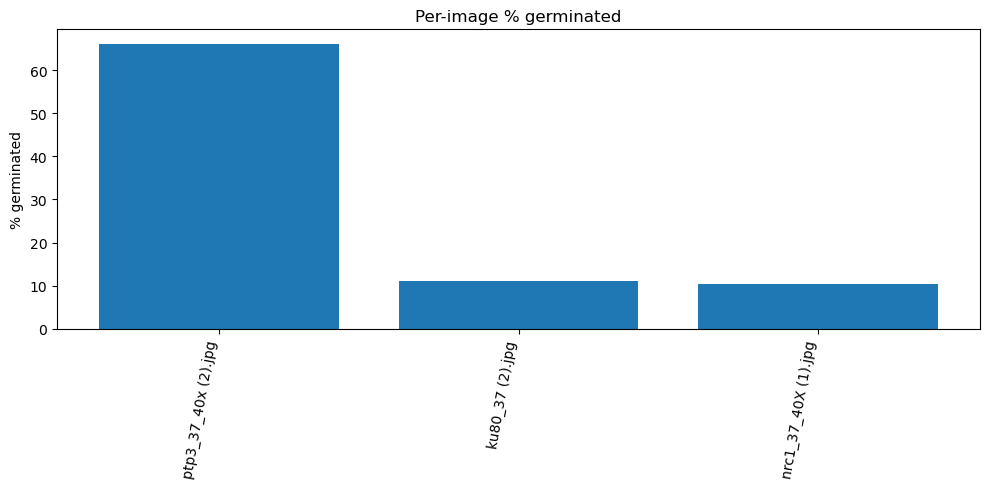

/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


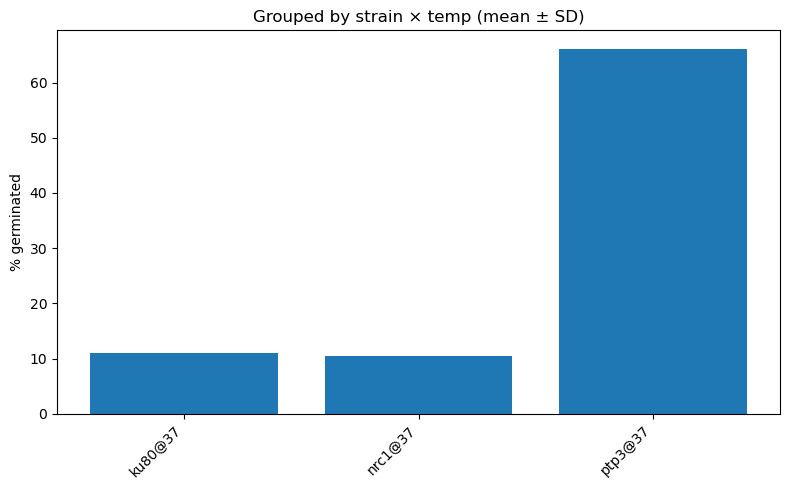

/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


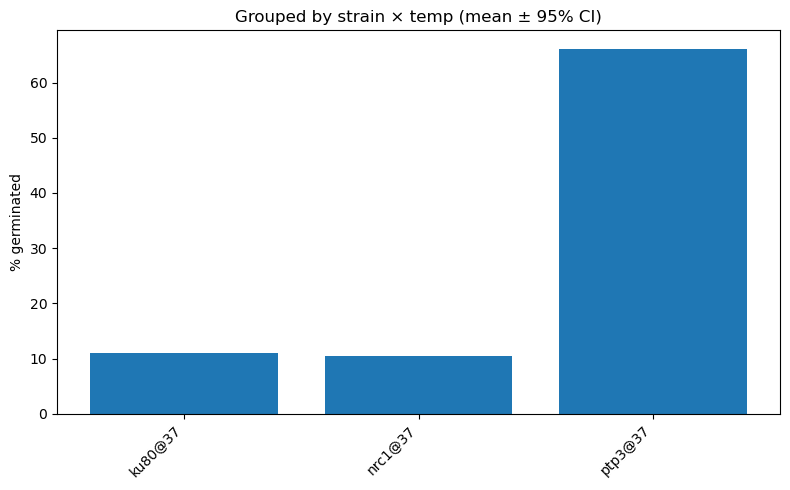

In [4]:
# === Batch Fungal Germination Counter (40×, robust v3) =======================
# Germinated if germ tube length ≥ 0.8 × that spore’s diameter (in µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# 40× tuned thresholds (patched to keep spore–tube connections)
MIN_AREA = 200           # px^2 (raise if fragments remain: 170–200)
MAX_AREA = 1800          # px^2 (lower if big blobs slip through)
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 0       # <-- no opening; don't break thin tubes
HOLE_AREA = 96
WATERSHED_SPLIT = True

# Adaptive Sauvola (gentler) for 40×
SAUVOLA_WINDOW = 41
SAUVOLA_K = 0.12

# Scale & germination rule
UM_PER_PX = 0.22         # <-- set from your 100 µm scale bar
MIN_TUBE_MULTIPLE = 1.5  # tube must be ≥ 0.8× that spore’s diameter
BORDERLINE_UM = 1.0

# debris/shape guards (looser to keep thin hyphae)
MIN_SOLIDITY = 0.80      # kept for reference, not used directly now
MIN_CIRCULARITY = 0.55   # kept for reference, not used directly now
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)

    # ---- robust masking: try multiple methods, pick best ----
    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)           # solid spores (no ring fragments)
        # no opening; DO a slightly stronger closing to keep spore–tube bridges
        bw = morphology.binary_closing(bw, morphology.disk(2))
        return bw

    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)
        frac_big = (max(areas)/max(1, int(mask.sum()))) if areas else 1.0
        return (n_ok, -frac_big)  # higher is better

    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bwN = cleanup(blur > thN)
    bwI = cleanup(blur_inv > thI)

    otsu = filters.threshold_otsu(blur_inv)
    yen  = filters.threshold_yen(blur_inv)
    tri  = filters.threshold_triangle(blur_inv)
    bwO = cleanup(blur_inv > otsu)
    bwY = cleanup(blur_inv > yen)
    bwT = cleanup(blur_inv > tri)

    candidates = [("sauv_normal", bwN), ("sauv_invert", bwI),
                  ("otsu_invert", bwO), ("yen_invert", bwY), ("tri_invert", bwT)]
    name, bw, _ = max(((nm, m, score_mask(m)) for nm, m in candidates), key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (denser split) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    # denser seeding: 0.30 × median spore diameter, clipped to 10–16 px
    #min_dist = int(np.clip(0.30 * med_eq_px, 10, 16))
    #min_dist = int(np.clip(0.35 * med_eq_px, 12, 18))
    min_dist = int(np.clip(0.40 * med_eq_px, 14, 20))

    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: if under-segmented (giant component), try h-maxima split
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.45 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ 0.8× diameter) ----
    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))

        # Looser debris guard: drop only wisps; keep thin hyphae
        if (solidity < 0.45 and circularity < 0.25):
            continue

        equiv_px = p.equivalent_diameter

        # --- measure skeleton on a 1-px dilated region to keep continuity
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(1))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)
        #cutoff_um = MIN_TUBE_MULTIPLE * equiv_um
        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, 5.0)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity",
            "is_germinated","margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # PLOTS
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
        plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± SD)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± 95% CI)")
        plt.tight_layout()
        plt.show()


Found 3 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ptp3_37_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1).jpg']
ku80_37 (2).jpg -> N=84  germinated=12  (14.3%)  mask=otsu_invert  seed_min_dist=15  overlay=ku80_37 (2)_overlay.png
nrc1_37_40X (1).jpg -> N=44  germinated=3  (6.8%)  mask=otsu_invert  seed_min_dist=15  overlay=nrc1_37_40X (1)_overlay.png
ptp3_37_40x (2).jpg -> N=741  germinated=273  (36.8%)  mask=otsu_invert  seed_min_dist=15  overlay=ptp3_37_40x (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_Bar

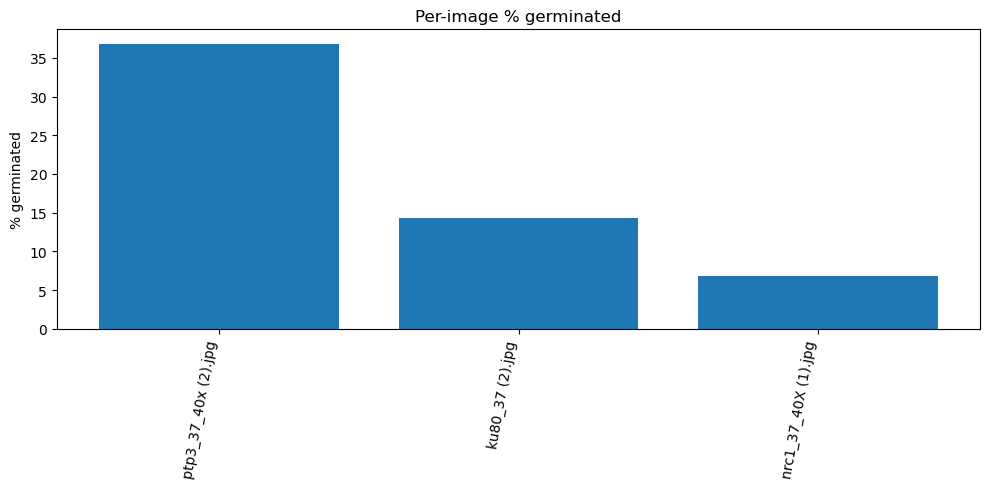

/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


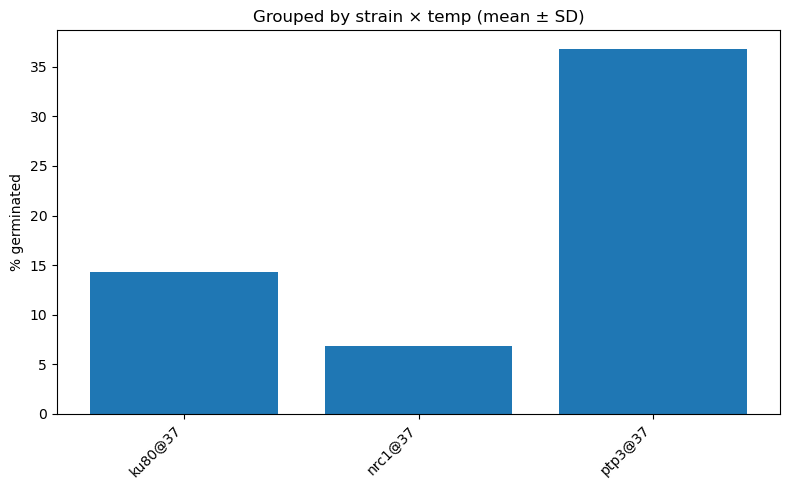

/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr2/people/shollyt22/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


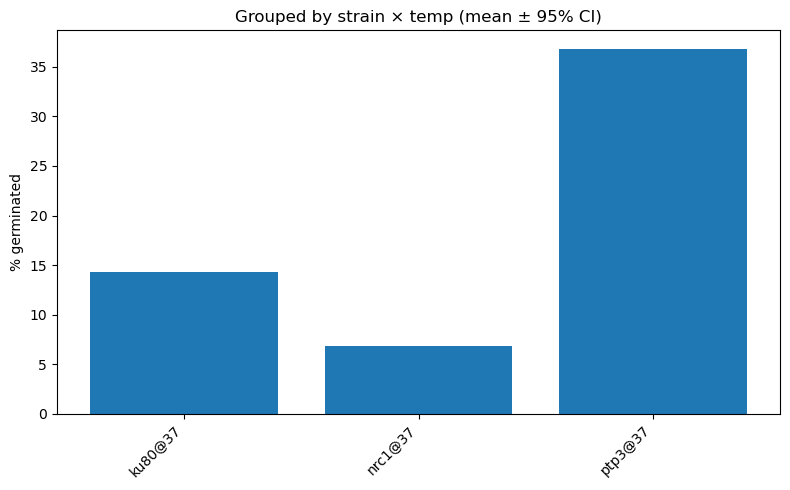

In [5]:
# === Batch Fungal Germination Counter (40×, consistent replicates) ===========
# Germinated if germ tube length ≥ max(1.5× spore diameter, 5 µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# 40× tuned thresholds (consistency-focused)
MIN_AREA = 220           # px^2 (filters lingering fragments)
MAX_AREA = 1800          # px^2 (prevents huge merged blobs)
GAUSSIAN_SIGMA = 1.0
HOLE_AREA = 96
WATERSHED_SPLIT = True

# Adaptive Sauvola for 40×
SAUVOLA_WINDOW = 41
SAUVOLA_K = 0.12

# Scale & germination rule
UM_PER_PX = 0.22         # <-- set using your scale bar if different
MIN_TUBE_MULTIPLE = 1.5  # relative component of cutoff
ABS_TUBE_MIN_UM = 5.0    # absolute minimum tube length
BORDERLINE_UM = 1.0

# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)

    # ---- robust masking: try multiple methods, pick best ----
    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)                      # solid spores
        bw = morphology.binary_closing(bw, morphology.disk(3))  # stronger bridge (no opening)
        return bw

    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)
        frac_big = (max(areas)/max(1, int(mask.sum()))) if areas else 1.0
        return (n_ok, -frac_big)  # higher is better

    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bwN = cleanup(blur > thN)
    bwI = cleanup(blur_inv > thI)

    otsu = filters.threshold_otsu(blur_inv)
    yen  = filters.threshold_yen(blur_inv)
    tri  = filters.threshold_triangle(blur_inv)
    bwO = cleanup(blur_inv > otsu)
    bwY = cleanup(blur_inv > yen)
    bwT = cleanup(blur_inv > tri)

    candidates = [("sauv_normal", bwN), ("sauv_invert", bwI),
                  ("otsu_invert", bwO), ("yen_invert", bwY), ("tri_invert", bwT)]
    name, bw, _ = max(((nm, m, score_mask(m)) for nm, m in candidates), key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (looser to avoid over-splits) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    # LESS DENSE: 0.45 × median diameter, clipped to 15–22 px
    min_dist = int(np.clip(0.45 * med_eq_px, 15, 22))

    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: if under-segmented (giant component), try h-maxima with higher h
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.55 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ max(1.5×D, 5 µm)) ----
    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        # looser debris filter: drop only stray wisps
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if (solidity < 0.45 and circularity < 0.25):
            continue

        equiv_px = p.equivalent_diameter

        # skeleton on a 1-px dilated region to ensure continuity
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(1))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)

        # STRICTER cutoff: relative AND absolute minimum
        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, ABS_TUBE_MIN_UM)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity",
            "is_germinated","margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # (optional) plots
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
        plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± SD)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± 95% CI)")
        plt.tight_layout()
        plt.show()


Found 3 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ptp3_37_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1).jpg']
ku80_37 (2).jpg -> N=48  germinated=1  (2.1%)  mask=feat_yen  seed_min_dist=17  overlay=ku80_37 (2)_overlay.png
nrc1_37_40X (1).jpg -> N=27  germinated=2  (7.4%)  mask=feat_otsu  seed_min_dist=15  overlay=nrc1_37_40X (1)_overlay.png
ptp3_37_40x (2).jpg -> N=36  germinated=2  (5.6%)  mask=feat_otsu  seed_min_dist=15  overlay=ptp3_37_40x (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencin

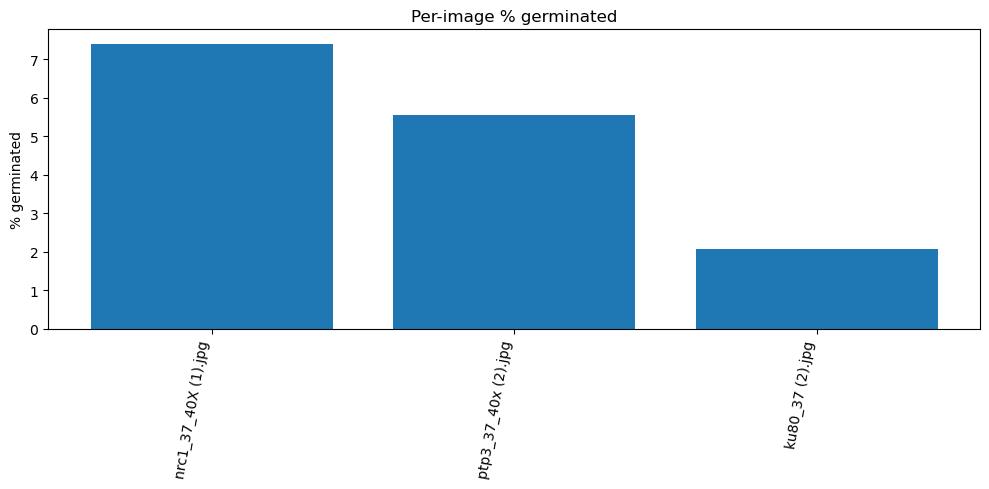

In [6]:
# === Batch Fungal Germination Counter (40×, noise-robust) ====================
# Germinated if germ tube length ≥ max(1.5× spore diameter, 5 µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Size gates & seeding tuned for consistency across replicates
MIN_AREA = 220           # px^2 (raise to 240 if tiny specks persist)
MAX_AREA = 1800          # px^2
GAUSSIAN_SIGMA = 1.0
HOLE_AREA = 96

# Germination rule
UM_PER_PX = 0.22         # <-- set from your scale bar
MIN_TUBE_MULTIPLE = 1.5  # relative minimum
ABS_TUBE_MIN_UM = 5.0    # absolute minimum (µm)
BORDERLINE_UM = 1.0

# Feature/contrast gating (new)
TOPHAT_RADIUS = 15       # px ~ 3–4 µm at 40×; adjust if needed
FEAT_MIN = 0.06          # min mean feature intensity inside a component (0–1)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & mild enhance (avoid over-boosting noise) ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = filters.gaussian(gray, sigma=GAUSSIAN_SIGMA)

    # ---- background suppression via top-hat on both polarities ----
    disk = morphology.disk(TOPHAT_RADIUS)
    wh = morphology.white_tophat(g, footprint=disk)        # bright features on gray
    bh = morphology.white_tophat(1.0 - g, footprint=disk)  # bright features on inverted (i.e., dark on gray)
    feat = np.maximum(wh, bh)   # feature image highlighting spores/hyphae
    feat = feat / (feat.max() + 1e-8)

    # ---- threshold candidates ON THE FEATURE IMAGE (multiple ways) ----
    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)
        bw = morphology.binary_closing(bw, morphology.disk(3))  # bridge tiny gaps (keeps tube+spore)
        return bw

    # global thresholds on feature image
    try:
        th_o = filters.threshold_otsu(feat)
    except ValueError:
        th_o = 0.0
    try:
        th_y = filters.threshold_yen(feat)
    except ValueError:
        th_y = 0.0
    try:
        th_t = filters.threshold_triangle(feat)
    except ValueError:
        th_t = 0.0

    bwO = cleanup(feat > th_o)
    bwY = cleanup(feat > th_y)
    bwT = cleanup(feat > th_t)

    # adaptive on original blur (keep for hard cases)
    thN = filters.threshold_sauvola(g,         window_size=41, k=0.12)
    thI = filters.threshold_sauvola(1.0 - g,   window_size=41, k=0.12)
    bwN = cleanup(g > thN)
    bwI = cleanup((1.0 - g) > thI)

    # score masks: prefer many plausibly-sized components & small biggest blob
    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)
        frac_big = (max(areas)/max(1, int(mask.sum()))) if areas else 1.0
        return (n_ok, -frac_big)

    candidates = [("feat_otsu", bwO), ("feat_yen", bwY), ("feat_tri", bwT),
                  ("sauv_normal", bwN), ("sauv_invert", bwI)]
    name, bw, _ = max(((nm, m, score_mask(m)) for nm, m in candidates), key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (looser to avoid over-splits) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    min_dist = int(np.clip(0.45 * med_eq_px, 15, 22))  # <- consistent setting that worked
    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # fallback: stronger peak suppression if one giant blob
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.55 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify with contrast gating ----
    props = measure.regionprops(labels, intensity_image=feat)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        # NEW: component must be visible on the feature image
        mean_feat = float(p.mean_intensity) if hasattr(p, "mean_intensity") else 0.0
        if mean_feat < FEAT_MIN:
            continue

        # very loose shape rejector: only drop wisps
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if (solidity < 0.45 and circularity < 0.25):
            continue

        # measure tube length on a 1-px dilated region to ensure continuity
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(1))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_px = p.equivalent_diameter
        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)

        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, ABS_TUBE_MIN_UM)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "mean_feat": mean_feat,
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","mean_feat","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity","is_germinated",
            "margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # (optional) quick plots
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()


Found 3 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ptp3_37_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1).jpg']
ku80_37 (2).jpg -> N=87  germinated=11  (12.6%)  mask=yen_invert  seed_min_dist=15  overlay=ku80_37 (2)_overlay.png


/tmp/ipykernel_2170153/2803087399.py:139: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))


nrc1_37_40X (1).jpg -> N=34  germinated=0  (0.0%)  mask=otsu_invert  seed_min_dist=15  overlay=nrc1_37_40X (1)_overlay.png
ptp3_37_40x (2).jpg -> N=36  germinated=2  (5.6%)  mask=feat_otsu  seed_min_dist=15  overlay=ptp3_37_40x (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_perimage_summary.csv


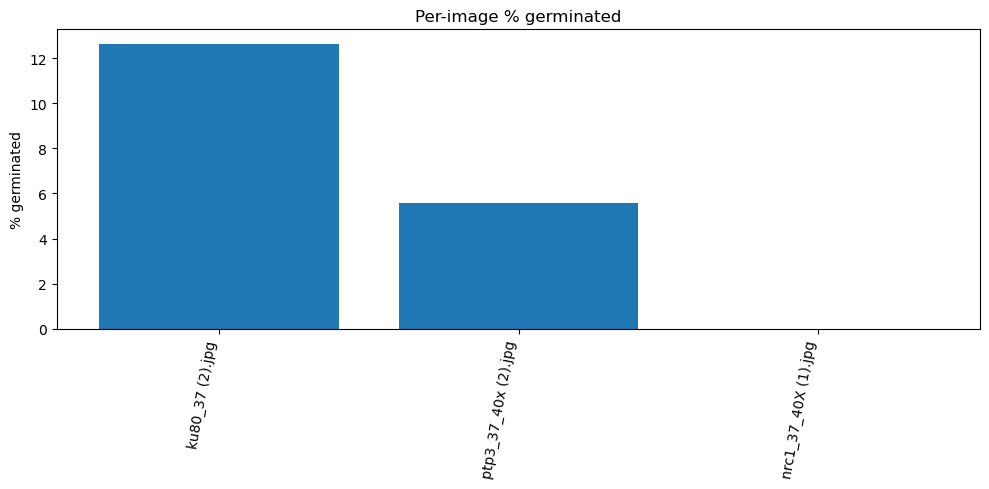

In [7]:
# === Batch Fungal Germination Counter (40×, hybrid + noise-robust) ===========
# Germinated if germ tube length ≥ max(1.5× spore diameter, 5 µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Size gates & seeding tuned for consistency
MIN_AREA = 220           # px^2 (raise to 240 if tiny specks persist)
MAX_AREA = 1800          # px^2
GAUSSIAN_SIGMA = 1.0
HOLE_AREA = 96

# Germination rule
UM_PER_PX = 0.22         # <-- set from your scale bar
MIN_TUBE_MULTIPLE = 1.5  # relative minimum
ABS_TUBE_MIN_UM = 5.0    # absolute minimum (µm)
BORDERLINE_UM = 1.0

# Feature/contrast gating
TOPHAT_RADIUS = 15       # px (~3–4 µm @ 40×)
FEAT_MIN = 0.035         # min mean feature intensity inside a component (0–1)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & mild enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = filters.gaussian(gray, sigma=GAUSSIAN_SIGMA)

    # ---- background suppression via top-hat (feature image) ----
    disk = morphology.disk(TOPHAT_RADIUS)
    wh = morphology.white_tophat(g, footprint=disk)
    bh = morphology.white_tophat(1.0 - g, footprint=disk)
    feat = np.maximum(wh, bh)
    feat = feat / (feat.max() + 1e-8)

    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)
        bw = morphology.binary_closing(bw, morphology.disk(3))  # bridge tiny gaps
        return bw

    def safe_thresh(fn, arr):
        try:
            return fn(arr)
        except ValueError:
            return 0.0

    # --- candidate masks on FEATURE image ---
    th_of = safe_thresh(filters.threshold_otsu,     feat)
    th_yf = safe_thresh(filters.threshold_yen,      feat)
    th_tf = safe_thresh(filters.threshold_triangle, feat)
    bw_feat_otsu = cleanup(feat > th_of)
    bw_feat_yen  = cleanup(feat > th_yf)
    bw_feat_tri  = cleanup(feat > th_tf)

    # --- candidate masks on ORIGINAL (for clean fields) ---
    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    SAUVOLA_WINDOW, SAUVOLA_K = 41, 0.12
    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw_sauv_n = cleanup(blur > thN)
    bw_sauv_i = cleanup(blur_inv > thI)

    to = safe_thresh(filters.threshold_otsu,     blur_inv)
    ty = safe_thresh(filters.threshold_yen,      blur_inv)
    tt = safe_thresh(filters.threshold_triangle, blur_inv)
    bw_otsu_i = cleanup(blur_inv > to)
    bw_yen_i  = cleanup(blur_inv > ty)
    bw_tri_i  = cleanup(blur_inv > tt)

    # --- scoring: more plausible objects, low confetti, not over-merged ---
    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        if not areas:
            return (-1e9,)  # worst
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)

        small = sum(a for a in areas if a < MIN_AREA)
        confetti = small / max(1, int(mask.sum()))  # tiny specks fraction

        frac_big = max(areas) / max(1, int(mask.sum()))  # over-merge indicator

        # target range for n_ok (tuned for 40× fields)
        lo, hi = 30, 200
        band_pen = 0.0
        if n_ok < lo:
            band_pen = - (lo - n_ok) * 0.75
        elif n_ok > hi:
            band_pen = - (n_ok - hi) * 0.10

        return (n_ok + band_pen) - 150.0*confetti - 5.0*frac_big

    candidates = [
        ("feat_otsu", bw_feat_otsu),
        ("feat_yen",  bw_feat_yen),
        ("feat_tri",  bw_feat_tri),
        ("sauv_normal", bw_sauv_n),
        ("sauv_invert", bw_sauv_i),
        ("otsu_invert", bw_otsu_i),
        ("yen_invert",  bw_yen_i),
        ("tri_invert",  bw_tri_i),
    ]
    scored = [(nm, m, score_mask(m)) for nm, m in candidates]
    name, bw, _ = max(scored, key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (looser to avoid over-splits) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    min_dist = int(np.clip(0.45 * med_eq_px, 15, 22))  # consistent with your tuned set
    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: stronger peak suppression if one giant blob
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.55 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ max(1.5×D, 5 µm)) with contrast gate ----
    props = measure.regionprops(labels, intensity_image=feat)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        mean_feat = float(p.mean_intensity) if hasattr(p, "mean_intensity") else 0.0
        if mean_feat < FEAT_MIN:
            continue  # drop flat background blobs

        # drop only obvious wisps
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if (solidity < 0.45 and circularity < 0.25):
            continue

        # measure skeleton on a 1-px dilated region for continuity
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(1))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_px = p.equivalent_diameter
        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)

        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, ABS_TUBE_MIN_UM)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "mean_feat": mean_feat,
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","mean_feat","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity","is_germinated",
            "margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # Optional quick plots
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()


Found 3 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ptp3_37_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/ku80_37 (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1).jpg']
ku80_37 (2).jpg -> N=87  germinated=13  (14.9%)  mask=yen_invert  seed_min_dist=15  overlay=ku80_37 (2)_overlay.png


/tmp/ipykernel_2170153/474934045.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/nrc1_37_40X (1)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))


nrc1_37_40X (1).jpg -> N=34  germinated=0  (0.0%)  mask=otsu_invert  seed_min_dist=15  overlay=nrc1_37_40X (1)_overlay.png
ptp3_37_40x (2).jpg -> N=36  germinated=2  (5.6%)  mask=feat_otsu  seed_min_dist=15  overlay=ptp3_37_40x (2)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025/germination_measurements_all_perimage_summary.csv


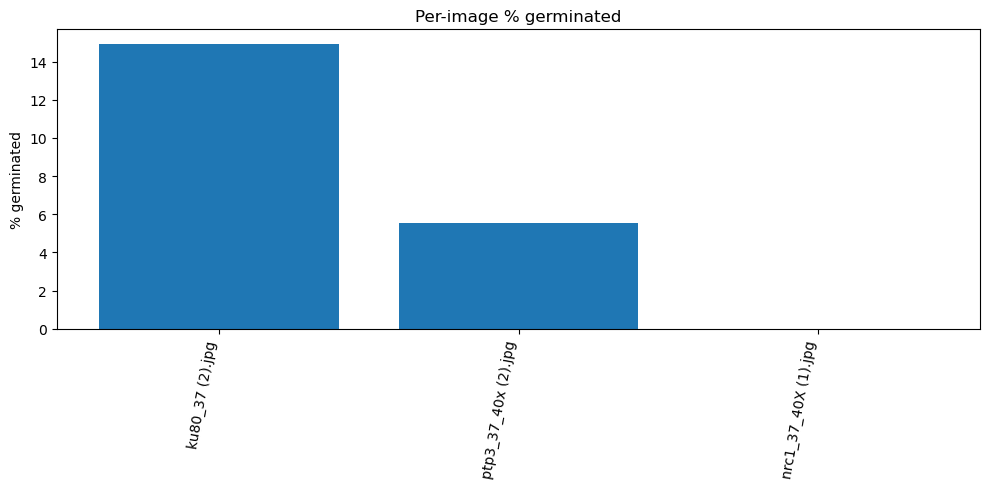

In [8]:
# === Batch Fungal Germination Counter (40×, hybrid + robust v2) ==============
# Germinated if germ tube length ≥ max(1.3× spore diameter, 5 µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_09_2025"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Size gates & seeding tuned for consistency
MIN_AREA = 220           # px^2 (raise to 240 if tiny specks persist)
MAX_AREA = 1800          # px^2
GAUSSIAN_SIGMA = 1.0
HOLE_AREA = 96

# Germination rule
UM_PER_PX = 0.22         # <-- set from your scale bar
MIN_TUBE_MULTIPLE = 1.3  # relative minimum (was 1.5)
ABS_TUBE_MIN_UM = 5.0    # absolute minimum (µm)
BORDERLINE_UM = 1.0

# Skeleton continuity (NEW: more forgiving)
SKELETON_DILATE = 2      # was 1

# Feature/contrast gating
TOPHAT_RADIUS = 15       # px (~3–4 µm @ 40×)
FEAT_MIN = 0.035         # min mean feature intensity inside a component (0–1)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & mild enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = filters.gaussian(gray, sigma=GAUSSIAN_SIGMA)

    # ---- background suppression via top-hat (feature image) ----
    disk = morphology.disk(TOPHAT_RADIUS)
    wh = morphology.white_tophat(g, footprint=disk)
    bh = morphology.white_tophat(1.0 - g, footprint=disk)
    feat = np.maximum(wh, bh)
    feat = feat / (feat.max() + 1e-8)

    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)
        bw = morphology.binary_closing(bw, morphology.disk(3))  # bridge tiny gaps
        return bw

    def safe_thresh(fn, arr):
        try:
            return fn(arr)
        except ValueError:
            return 0.0

    # --- candidate masks on FEATURE image ---
    th_of = safe_thresh(filters.threshold_otsu,     feat)
    th_yf = safe_thresh(filters.threshold_yen,      feat)
    th_tf = safe_thresh(filters.threshold_triangle, feat)
    bw_feat_otsu = cleanup(feat > th_of)
    bw_feat_yen  = cleanup(feat > th_yf)
    bw_feat_tri  = cleanup(feat > th_tf)

    # --- candidate masks on ORIGINAL (for clean fields) ---
    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    SAUVOLA_WINDOW, SAUVOLA_K = 41, 0.12
    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw_sauv_n = cleanup(blur > thN)
    bw_sauv_i = cleanup(blur_inv > thI)

    to = safe_thresh(filters.threshold_otsu,     blur_inv)
    ty = safe_thresh(filters.threshold_yen,      blur_inv)
    tt = safe_thresh(filters.threshold_triangle, blur_inv)
    bw_otsu_i = cleanup(blur_inv > to)
    bw_yen_i  = cleanup(blur_inv > ty)
    bw_tri_i  = cleanup(blur_inv > tt)

    # --- scoring: plausible count, low confetti, not over-merged,
    #              prefer masks with strong feature signal, avoid ultra-sparse ---
    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        if not areas:
            return (-1e9,)  # worst score
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)

        # tiny specks fraction (confetti)
        small = sum(a for a in areas if a < MIN_AREA)
        confetti = small / max(1, int(mask.sum()))

        # over-merge indicator
        frac_big = max(areas) / max(1, int(mask.sum()))

        # target range for n_ok (tuned for 40× fields)
        lo, hi = 30, 200
        band_pen = 0.0
        if n_ok < lo:
            band_pen = - (lo - n_ok) * 0.75
        elif n_ok > hi:
            band_pen = - (n_ok - hi) * 0.10

        # NEW: reward masks whose pixels have strong feature response
        feat_mean = float(feat[mask].mean()) if mask.any() else 0.0
        feat_bonus = 20.0 * feat_mean

        # NEW: penalize ultra-sparse masks (low-contrast globals)
        fill = mask.mean()  # fraction of image marked
        sparse_pen = 0.0 if fill >= 0.005 else -50.0

        return (n_ok + band_pen) - 150.0*confetti - 5.0*frac_big + feat_bonus + sparse_pen

    candidates = [
        ("feat_otsu", bw_feat_otsu),
        ("feat_yen",  bw_feat_yen),
        ("feat_tri",  bw_feat_tri),
        ("sauv_normal", bw_sauv_n),
        ("sauv_invert", bw_sauv_i),
        ("otsu_invert", bw_otsu_i),
        ("yen_invert",  bw_yen_i),
        ("tri_invert",  bw_tri_i),
    ]
    scored = [(nm, m, score_mask(m)) for nm, m in candidates]
    name, bw, _ = max(scored, key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (looser to avoid over-splits) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    min_dist = int(np.clip(0.45 * med_eq_px, 15, 22))
    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: stronger peak suppression if one giant blob
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.55 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ max(1.3×D, 5 µm)) with contrast gate ----
    props = measure.regionprops(labels, intensity_image=feat)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        mean_feat = float(p.mean_intensity) if hasattr(p, "mean_intensity") else 0.0
        if mean_feat < FEAT_MIN:
            continue  # drop flat background blobs

        # drop only obvious wisps
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if (solidity < 0.45 and circularity < 0.25):
            continue

        # measure skeleton on a dilated region (NEW: SKELETON_DILATE=2)
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(SKELETON_DILATE))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_px = p.equivalent_diameter
        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)

        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, ABS_TUBE_MIN_UM)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "mean_feat": mean_feat,
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","mean_feat","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity","is_germinated",
            "margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # Optional quick plots
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()
